<a href="https://colab.research.google.com/github/araldi/Python_for_biomedical_data_analysis/blob/main/09_LinearModels_part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic regression
Instead of predicting within a quantitative range, logistic regression places the output into categories (binary classification prediction).

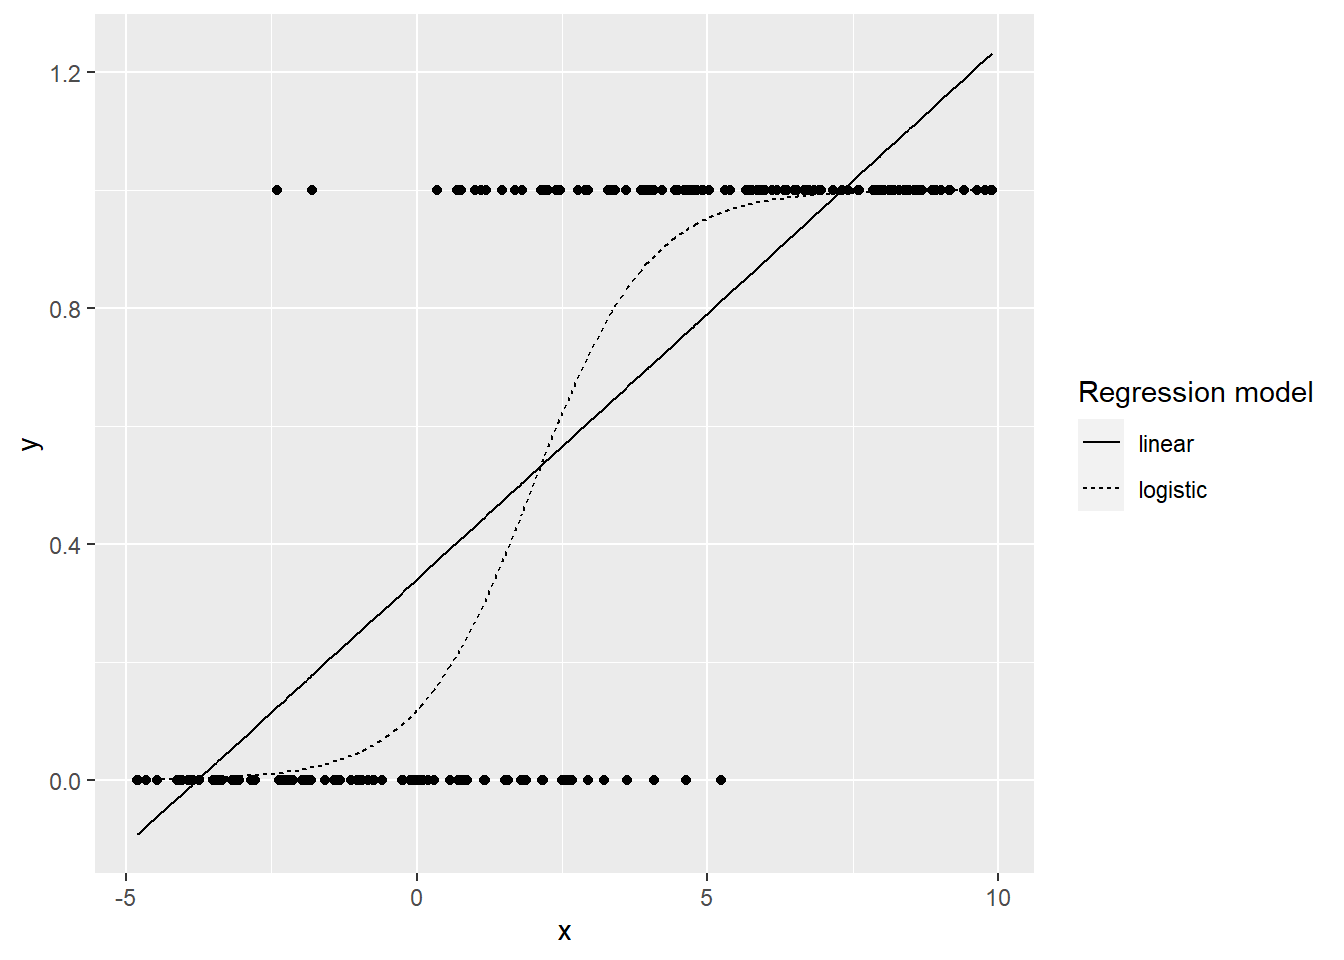


https://bookdown.org/roback/bookdown-BeyondMLR/ch-logreg.html







In a logistic regression model:

* we take linear combination (or weighted sum of the input features)
* we apply the sigmoid function to the result to obtain a number between 0 and 1
* this number represents the probability of the input being classified as "Yes"
* the cross entropy loss function is used to evaluate the results

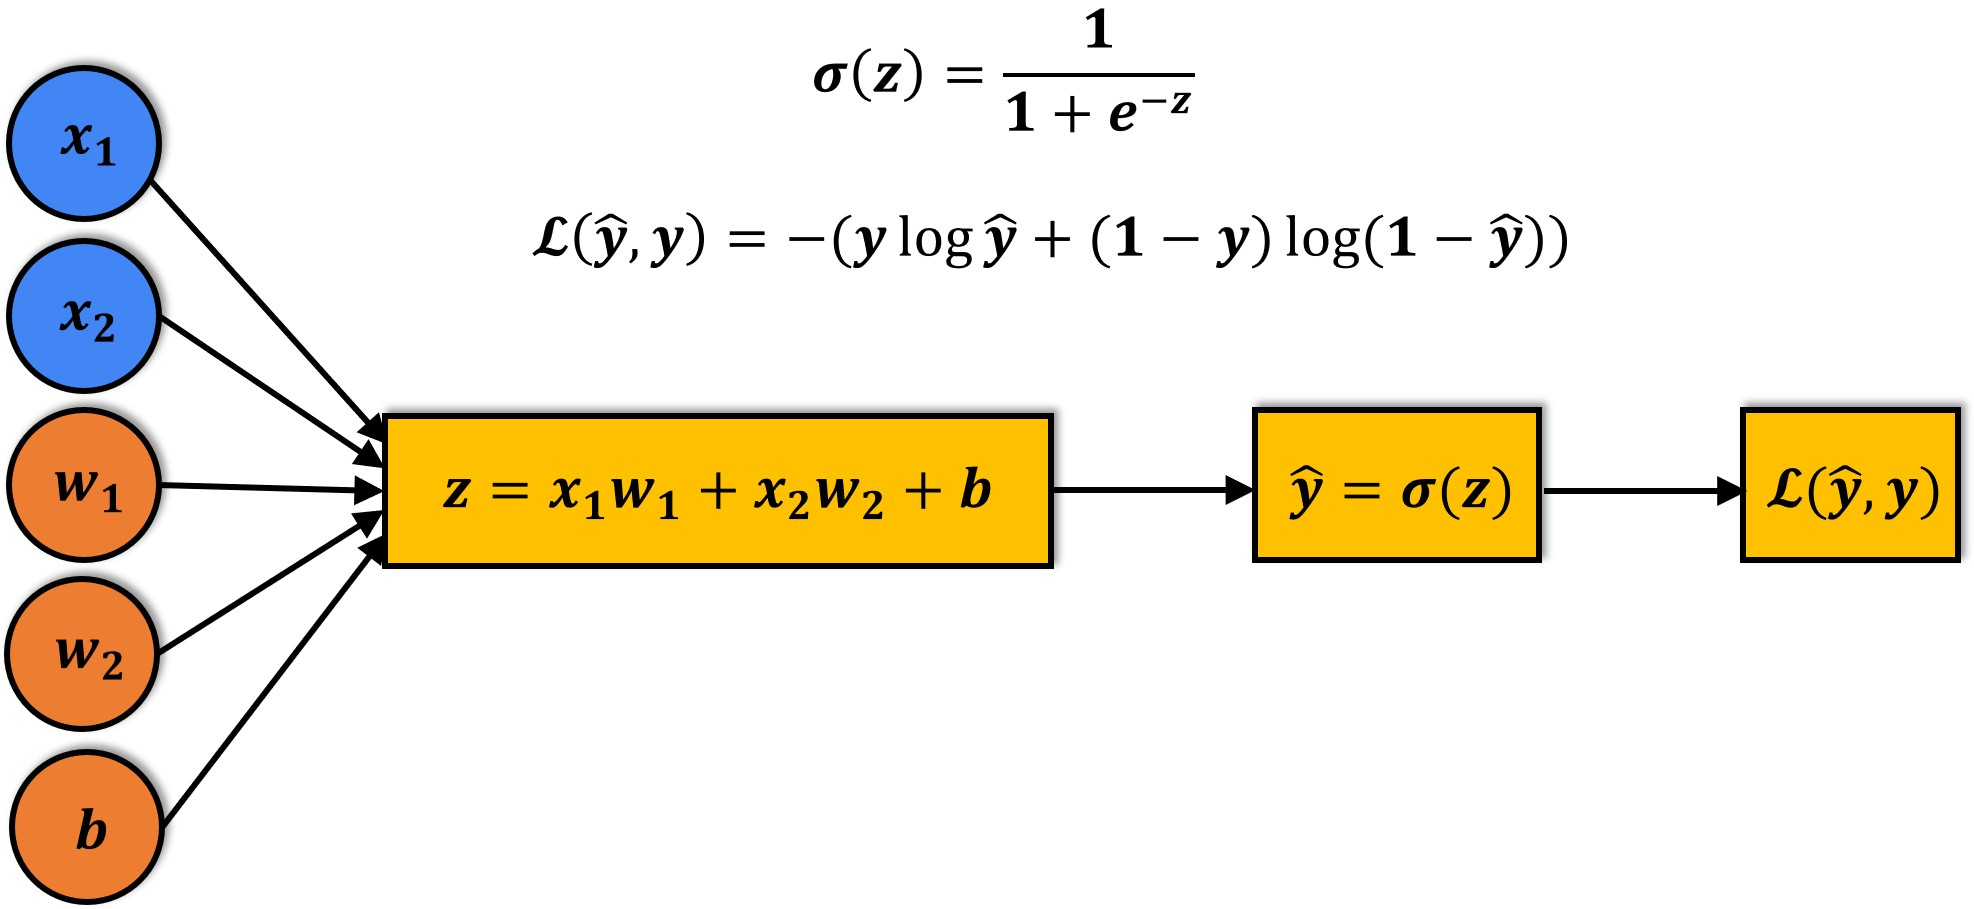

Let's predict if a breast cancer is benign or malignant based on radius, texture, perimeter, etc.

We will create a logistic regression model that models a training dataset, then use it to predict malignancy in a test dataset.

**Attribute Information:**

1) ID number

2) Diagnosis (M = malignant, B = benign)


3-32)

**Ten real-valued features are computed for each cell nucleus:**
a) radius (mean of distances from center to points on the perimeter)

b) texture (standard deviation of gray-scale values)

c) perimeter

d) area

e) smoothness (local variation in radius lengths)

f) compactness (perimeter^2 / area - 1.0)

g) concavity (severity of concave portions of the contour)

h) concave points (number of concave portions of the contour)

i) symmetry

j) fractal dimension ("coastline approximation" - 1)

The mean, standard error and "worst" or largest (mean of the three
largest values) of these features were computed for each image,
resulting in 30 features. For instance, field 3 is Mean Radius, field
13 is Radius SE, field 23 is Worst Radius.

All feature values are recoded with four significant digits.

Missing attribute values: none

Class distribution: 357 benign, 212 malignant

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
dataset_url = 'https://raw.githubusercontent.com/araldi/Python_for_biomedical_data_analysis/main/Files/Logistic_regression_data.csv'

breast = pd.read_csv(dataset_url)

### Exploratory analysis

In [4]:
breast.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [ ]:
feature_columns = breast.select_dtypes(exclude = ['int64','object']).columns
features = [i for i in feature_columns if 'Unnamed: 32' not in i]
features = [i.replace(' ', '_') for i in features]

len(features)

30

In [ ]:
features

['radius_mean',
 'texture_mean',
 'perimeter_mean',
 'area_mean',
 'smoothness_mean',
 'compactness_mean',
 'concavity_mean',
 'concave_points_mean',
 'symmetry_mean',
 'fractal_dimension_mean',
 'radius_se',
 'texture_se',
 'perimeter_se',
 'area_se',
 'smoothness_se',
 'compactness_se',
 'concavity_se',
 'concave_points_se',
 'symmetry_se',
 'fractal_dimension_se',
 'radius_worst',
 'texture_worst',
 'perimeter_worst',
 'area_worst',
 'smoothness_worst',
 'compactness_worst',
 'concavity_worst',
 'concave_points_worst',
 'symmetry_worst',
 'fractal_dimension_worst']

In [ ]:
breast.rename(columns = dict(zip(feature_columns, features)), inplace=True)

In [ ]:
breast

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN


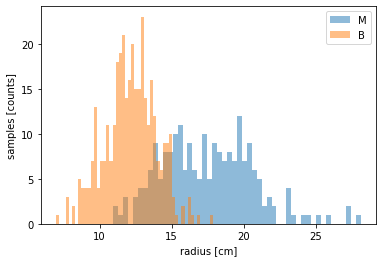

In [ ]:
#quick exploratory plot
m = breast['diagnosis'] == 'M'
b = breast['diagnosis'] == 'B'
plt.hist(x='radius_mean', data = breast[m], label = 'M', bins = 50, alpha = 0.5)
plt.hist(x='radius_mean', data = breast[b], label = 'B', bins = 50, alpha = 0.5)
plt.xlabel('radius [cm]')
plt.ylabel('samples [counts]')

plt.legend()


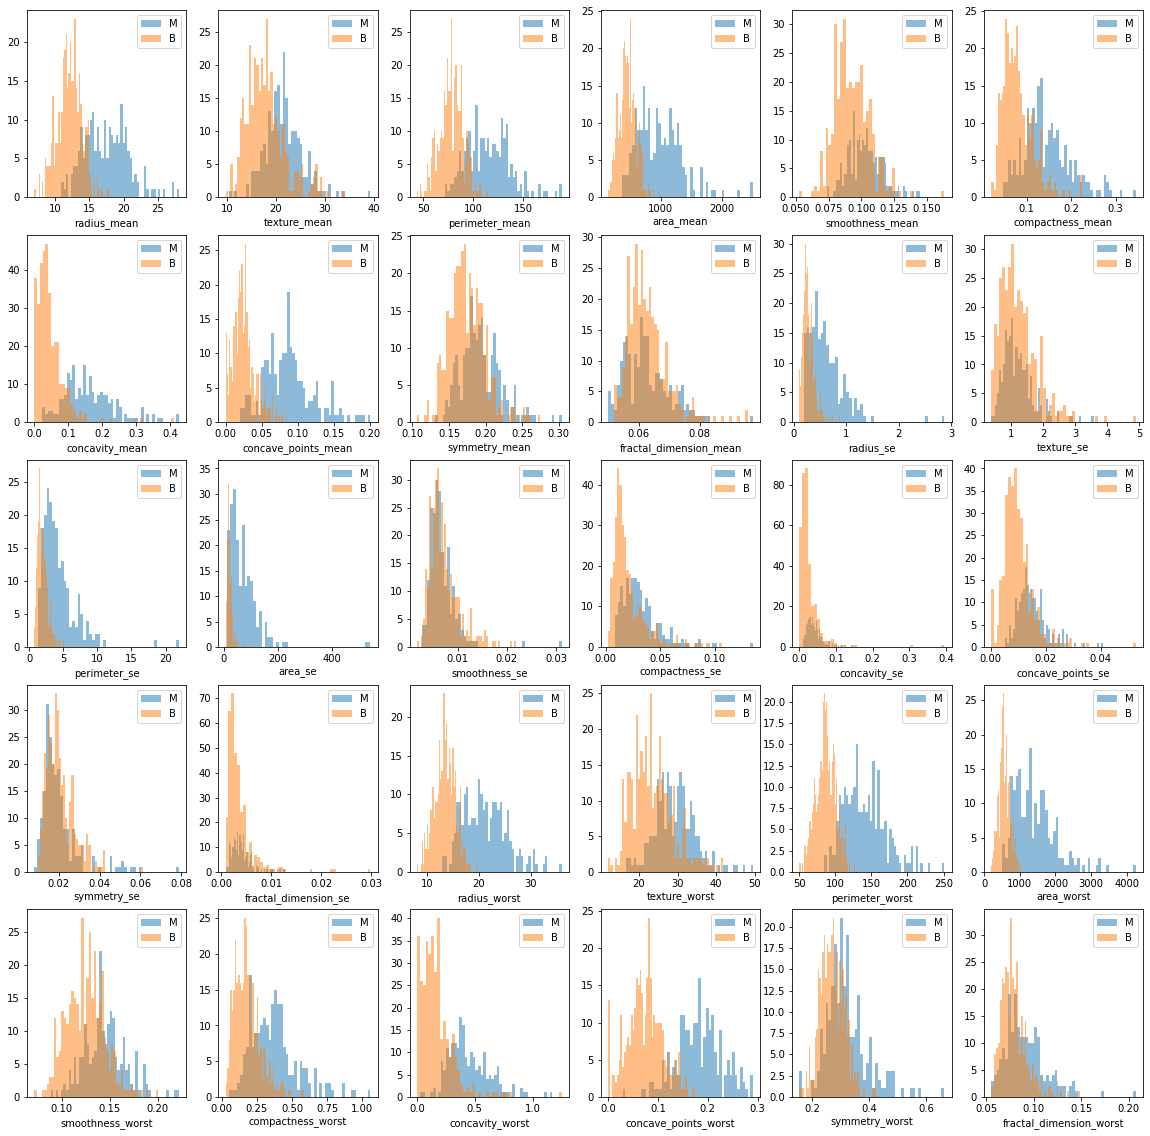

In [ ]:
# in-depth exploration of the features
plt.figure(figsize = (20,20))
i=1
m = breast['diagnosis'] == 'M'
b = breast['diagnosis'] == 'B'
for feature in features:

  plt.subplot(5,6, i)
  plt.hist(x=feature, data = breast[m], label = 'M', bins = 50, alpha = 0.5)
  plt.hist(x=feature, data = breast[b], label = 'B', bins = 50, alpha = 0.5)
  i = i+1
  plt.xlabel(feature)
  plt.legend()
plt.show()
plt.close()

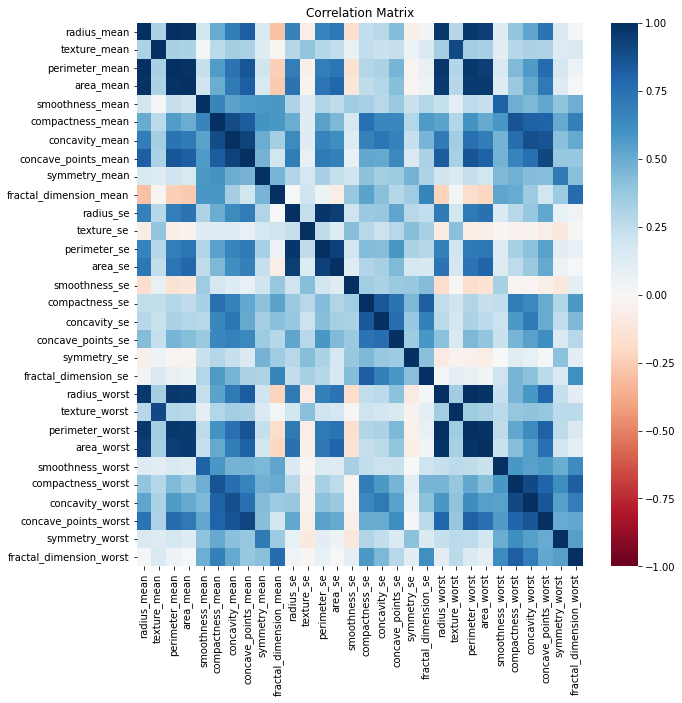

In [ ]:
# test the correlation among features
plt.figure(figsize=(20,20))
sns.heatmap(train_df[features].corr(),annot=True, cmap='RdBu', vmin=-1, vmax=1)
plt.title('Correlation Matrix');

# !!!!!
# high correlation between radius, perimeter, area --> keep just one of these features!

In [ ]:
features = [i for i in features if not any(e in i for e in ['area', 'perimeter'])]

### Transform the diagnosis in 0 or 1

In [ ]:
mask = breast['diagnosis'] == 'M'

breast.loc[mask, 'output'] = 1
breast.loc[~mask, 'output'] = 0

In [ ]:
breast

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32,output
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,NaN,1.0
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,NaN,1.0
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,NaN,1.0
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,NaN,1.0
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN,1.0
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN,1.0
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN,1.0
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN,1.0


### Divide the dataset in training dataset and testing dataset

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(breast, test_size=0.2, random_state=2022)


In [ ]:
train_df

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32,output
544,922297,B,13.87,20.70,89.77,584.8,0.09578,0.10180,0.036880,0.02369,...,99.17,688.6,0.1264,0.2037,0.13770,0.06845,0.2249,0.08492,NaN,0.0
226,88147101,B,10.44,15.46,66.62,329.6,0.10530,0.07722,0.006643,0.01216,...,73.47,395.4,0.1341,0.1153,0.02639,0.04464,0.2615,0.08269,NaN,0.0
325,89511502,B,12.67,17.30,81.25,489.9,0.10280,0.07664,0.031930,0.02107,...,88.70,574.4,0.1384,0.1212,0.10200,0.05602,0.2688,0.06888,NaN,0.0
559,925291,B,11.51,23.93,74.52,403.5,0.09261,0.10210,0.111200,0.04105,...,82.28,474.2,0.1298,0.2517,0.36300,0.09653,0.2112,0.08732,NaN,0.0
141,869104,M,16.11,18.05,105.10,813.0,0.09721,0.11370,0.094470,0.05943,...,129.00,1233.0,0.1314,0.2236,0.28020,0.12160,0.2792,0.08158,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,852552,M,16.65,21.38,110.00,904.6,0.11210,0.14570,0.152500,0.09170,...,177.00,2215.0,0.1805,0.3578,0.46950,0.20950,0.3613,0.09564,NaN,1.0
18,849014,M,19.81,22.15,130.00,1260.0,0.09831,0.10270,0.147900,0.09498,...,186.80,2398.0,0.1512,0.3150,0.53720,0.23880,0.2768,0.07615,NaN,1.0
240,88350402,B,13.64,15.60,87.38,575.3,0.09423,0.06630,0.047050,0.03731,...,94.11,683.4,0.1278,0.1291,0.15330,0.09222,0.2530,0.06510,NaN,0.0
173,871641,B,11.08,14.71,70.21,372.7,0.10060,0.05743,0.023630,0.02583,...,72.01,396.5,0.1216,0.0824,0.03938,0.04306,0.1902,0.07313,NaN,0.0


In [ ]:
test_df

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32,output
453,911201,B,14.530,13.98,93.86,644.2,0.10990,0.09242,0.06895,0.06495,...,103.10,749.9,0.1347,0.14780,0.13730,0.10690,0.2606,0.07810,NaN,0.0
153,87106,B,11.150,13.08,70.87,381.9,0.09754,0.05113,0.01982,0.01786,...,76.25,440.8,0.1341,0.08971,0.07116,0.05506,0.2859,0.06772,NaN,0.0
385,90291,M,14.600,23.29,93.97,664.7,0.08682,0.06636,0.08390,0.05271,...,102.20,758.2,0.1312,0.15810,0.26750,0.13590,0.2477,0.06836,NaN,1.0
67,859465,B,11.310,19.04,71.80,394.1,0.08139,0.04701,0.03709,0.02230,...,78.00,466.7,0.1290,0.09148,0.14440,0.06961,0.2400,0.06641,NaN,0.0
528,918192,B,13.940,13.17,90.31,594.2,0.12480,0.09755,0.10100,0.06615,...,94.52,653.3,0.1394,0.13640,0.15590,0.10150,0.2160,0.07253,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,882488,B,9.567,15.91,60.21,279.6,0.08464,0.04087,0.01652,0.01667,...,65.74,335.9,0.1504,0.09515,0.07161,0.07222,0.2757,0.08178,NaN,0.0
388,903011,B,11.270,15.50,73.38,392.0,0.08365,0.11140,0.10070,0.02757,...,79.73,450.0,0.1102,0.28090,0.30210,0.08272,0.2157,0.10430,NaN,0.0
384,902727,B,13.280,13.72,85.79,541.8,0.08363,0.08575,0.05077,0.02864,...,96.59,623.7,0.1166,0.26850,0.28660,0.09173,0.2736,0.07320,NaN,0.0
171,87163,M,13.430,19.63,85.84,565.4,0.09048,0.06288,0.05858,0.03438,...,116.60,993.6,0.1401,0.15460,0.26440,0.11600,0.2884,0.07371,NaN,1.0


### Scale the data

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


In [ ]:
input_cols = features
target_col = 'output'

In [ ]:
scaler.fit(train_df[features])
train_df[features] = scaler.transform(train_df[features])



In [ ]:
train_df

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32,output
544,922297,B,-0.055955,0.334807,-0.074122,-0.183103,-0.042860,-0.042485,-0.646152,-0.643657,...,-0.227195,-0.325798,-0.262873,-0.319339,-0.642079,-0.701544,-1.034791,0.058717,NaN,0.0
226,88147101,B,-1.051178,-0.913059,-1.046577,-0.927708,0.638402,-0.508435,-1.027508,-0.945635,...,-1.015921,-0.864491,0.070490,-0.876590,-1.167024,-1.067218,-0.455101,-0.064280,NaN,0.0
325,89511502,B,-0.404138,-0.474877,-0.432019,-0.459996,0.459500,-0.519429,-0.708582,-0.712276,...,-0.548516,-0.535617,0.256654,-0.839398,-0.810443,-0.892444,-0.339480,-0.825978,NaN,0.0
559,925291,B,-0.740715,1.104007,-0.714724,-0.712087,-0.269708,-0.036798,0.291190,-0.188988,...,-0.745544,-0.719713,-0.115674,-0.016759,0.420449,-0.270292,-1.251779,0.191090,NaN,0.0
141,869104,M,0.593987,-0.296270,0.569841,0.482723,0.059473,0.183097,0.080187,0.292395,...,0.688279,0.674421,-0.046404,-0.193894,0.029959,0.114733,-0.174760,-0.125503,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,852552,M,0.750669,0.496744,0.775673,0.749986,1.125018,0.789705,0.812076,1.137566,...,2.161386,2.478638,2.079331,0.652069,0.922709,1.464699,1.125582,0.649985,NaN,1.0
18,849014,M,1.667551,0.680114,1.615807,1.786947,0.138190,-0.025424,0.754059,1.223471,...,2.462145,2.814862,0.810817,0.382268,1.241986,1.914688,-0.212772,-0.424997,NaN,1.0
240,88350402,B,-0.122690,-0.879719,-0.174518,-0.210822,-0.153779,-0.715439,-0.517885,-0.286941,...,-0.382485,-0.335352,-0.202262,-0.789598,-0.568509,-0.336485,-0.589729,-1.034466,NaN,0.0
173,871641,B,-0.865480,-1.091666,-0.895773,-0.801953,0.302065,-0.883583,-0.813264,-0.587609,...,-1.060728,-0.862470,-0.470684,-1.083983,-1.105762,-1.091483,-1.584387,-0.591567,NaN,0.0


In [ ]:
scaler.fit(test_df[features])
test_df[features] = scaler.transform(test_df[features])

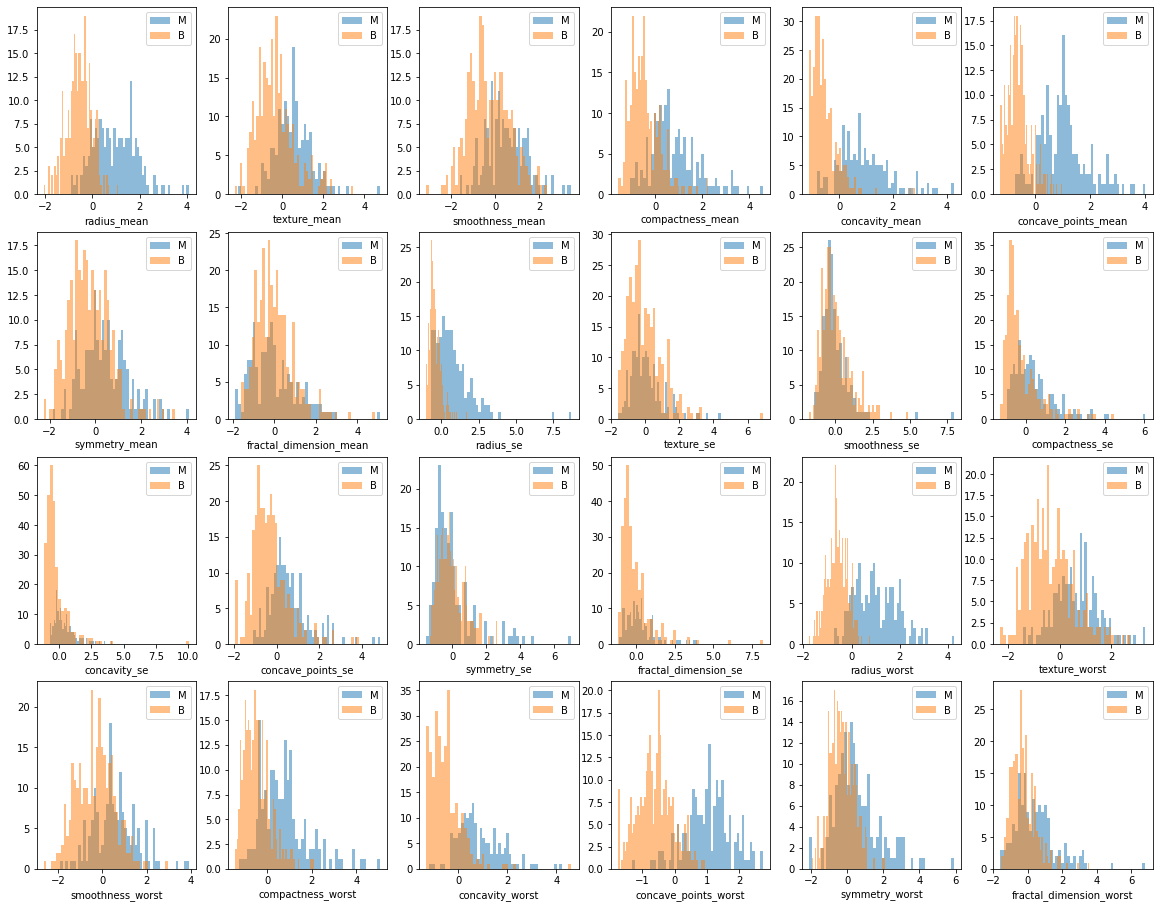

In [ ]:
# check that the scaling worked
plt.figure(figsize = (20,20))
i=1
for feature in features:
  m = train_df['output'] == 1
  b = train_df['output'] == 0
  plt.subplot(5,6, i)
  plt.hist(x=feature, data = train_df[m], label = 'M', bins = 50, alpha = 0.5)
  plt.hist(x=feature, data = train_df[b], label = 'B', bins = 50, alpha = 0.5)
  i = i+1
  plt.xlabel(feature)
  plt.legend()
plt.show()
plt.close()

In [ ]:
train_df#[1:]

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32,output
544,922297,B,-0.055955,0.334807,-0.074122,-0.183103,-0.042860,-0.042485,-0.646152,-0.643657,...,-0.227195,-0.325798,-0.262873,-0.319339,-0.642079,-0.701544,-1.034791,0.058717,NaN,0.0
226,88147101,B,-1.051178,-0.913059,-1.046577,-0.927708,0.638402,-0.508435,-1.027508,-0.945635,...,-1.015921,-0.864491,0.070490,-0.876590,-1.167024,-1.067218,-0.455101,-0.064280,NaN,0.0
325,89511502,B,-0.404138,-0.474877,-0.432019,-0.459996,0.459500,-0.519429,-0.708582,-0.712276,...,-0.548516,-0.535617,0.256654,-0.839398,-0.810443,-0.892444,-0.339480,-0.825978,NaN,0.0
559,925291,B,-0.740715,1.104007,-0.714724,-0.712087,-0.269708,-0.036798,0.291190,-0.188988,...,-0.745544,-0.719713,-0.115674,-0.016759,0.420449,-0.270292,-1.251779,0.191090,NaN,0.0
141,869104,M,0.593987,-0.296270,0.569841,0.482723,0.059473,0.183097,0.080187,0.292395,...,0.688279,0.674421,-0.046404,-0.193894,0.029959,0.114733,-0.174760,-0.125503,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,852552,M,0.750669,0.496744,0.775673,0.749986,1.125018,0.789705,0.812076,1.137566,...,2.161386,2.478638,2.079331,0.652069,0.922709,1.464699,1.125582,0.649985,NaN,1.0
18,849014,M,1.667551,0.680114,1.615807,1.786947,0.138190,-0.025424,0.754059,1.223471,...,2.462145,2.814862,0.810817,0.382268,1.241986,1.914688,-0.212772,-0.424997,NaN,1.0
240,88350402,B,-0.122690,-0.879719,-0.174518,-0.210822,-0.153779,-0.715439,-0.517885,-0.286941,...,-0.382485,-0.335352,-0.202262,-0.789598,-0.568509,-0.336485,-0.589729,-1.034466,NaN,0.0
173,871641,B,-0.865480,-1.091666,-0.895773,-0.801953,0.302065,-0.883583,-0.813264,-0.587609,...,-1.060728,-0.862470,-0.470684,-1.083983,-1.105762,-1.091483,-1.584387,-0.591567,NaN,0.0


### Training a logistic regression model

In [ ]:
import statsmodels.formula.api as smf

In [ ]:
# let's test the model with the two features that seem very predictive
model = smf.logit("output ~ radius_mean + concave_points_mean", data = train_df).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.191447
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 output   No. Observations:                  455
Model:                          Logit   Df Residuals:                      452
Method:                           MLE   Df Model:                            2
Date:                Thu, 27 Oct 2022   Pseudo R-squ.:                  0.7082
Time:                        18:15:46   Log-Likelihood:                -87.109
converged:                       True   LL-Null:                       -298.55
Covariance Type:            nonrobust   LLR p-value:                 1.489e-92
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.6839      0.198     -3.454      0.001      -1.072      -0.296
radius_mean             2.1560      0.426      5.061      0.000       1.321       2.991
concave_points_mean     3.0795      0.406      7.583      0.000       2.284       3.875
=======================================================================================
"""

In [ ]:
# since many features with mean, se and worst seem to be very correlating,
# let's explore the features by type (mean, se, or worst)

only_mean = [i for i in features if "_mean" in i]
only_se = [i for i in features if "_se" in i]
only_worst = [i for i in features if "_worst" in i]

In [ ]:
# use a loop to write the formula
formula_features = ''
for i in only_mean:
  i = i.replace(' ', '_')
  formula_features = i + " + " + formula_features
formula_features = formula_features[:-3]

# create and fit the model
model = smf.logit("output ~ %s" %formula_features, data = train_df).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.133266
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 output   No. Observations:                  455
Model:                          Logit   Df Residuals:                      446
Method:                           MLE   Df Model:                            8
Date:                Thu, 27 Oct 2022   Pseudo R-squ.:                  0.7969
Time:                        18:17:01   Log-Likelihood:                -60.636
converged:                       True   LL-Null:                       -298.55
Covariance Type:            nonrobust   LLR p-value:                 1.078e-97
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.6604      0.260     -2.536      0.011      -1.171      -0.150
fractal_dimension_mean     0.6835      0.677      1.010      0.313      -0.643       2.010
symmetry_mean              0.5379      0.354      1.517      0.129      -0.157       1.233
concave_points_mean        1.7249      1.117      1.544      0.123      -0.464       3.914
concavity_mean             2.1318      0.693      3.077      0.002       0.774       3.490
compactness_mean          -2.3986      0.922     -2.600      0.009      -4.207      -0.591
smoothness_mean            1.2466      0.551      2.263      0.024       0.167       2.326
texture_mean               1.5933      0.300      5.320      0.000       1.006       2.180
radius_mean                4.3868      1.037      4.232      0.000       2.355       6.419
==========================================================================================

Possibly complete quasi-separation: A fraction 0.16 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [ ]:
# use a loop to write the formula
formula_features = ''
for i in only_se:
  i = i.replace(' ', '_')
  formula_features = i + " + " + formula_features
formula_features = formula_features[:-3]

# create and fit the model
model = smf.logit("output ~ %s" %formula_features, data = train_df).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.326550
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 output   No. Observations:                  455
Model:                          Logit   Df Residuals:                      446
Method:                           MLE   Df Model:                            8
Date:                Thu, 27 Oct 2022   Pseudo R-squ.:                  0.5023
Time:                        18:13:09   Log-Likelihood:                -148.58
converged:                       True   LL-Null:                       -298.55
Covariance Type:            nonrobust   LLR p-value:                 4.249e-60
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.4476      0.164     -2.735      0.006      -0.768      -0.127
fractal_dimension_se    -1.1982      0.320     -3.739      0.000      -1.826      -0.570
symmetry_se             -0.8388      0.206     -4.070      0.000      -1.243      -0.435
concave_points_se        0.4954      0.325      1.526      0.127      -0.141       1.132
concavity_se             0.0479      0.248      0.193      0.847      -0.437       0.533
compactness_se           1.5859      0.405      3.918      0.000       0.793       2.379
smoothness_se           -0.6491      0.206     -3.149      0.002      -1.053      -0.245
texture_se              -0.2043      0.204     -1.002      0.316      -0.604       0.195
radius_se                3.4509      0.424      8.134      0.000       2.619       4.282
========================================================================================
"""

In [ ]:
# use a loop to write the formula
formula_features = ''
for i in only_worst:
  i = i.replace(' ', '_')
  formula_features = i + " + " + formula_features
formula_features = formula_features[:-3]

# create and fit the model
model = smf.logit("output ~ %s" %formula_features, data = train_df).fit()
model.summary()

# !!! this seems to be the model that fits the data the best

Optimization terminated successfully.
         Current function value: 0.083006
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 output   No. Observations:                  455
Model:                          Logit   Df Residuals:                      446
Method:                           MLE   Df Model:                            8
Date:                Thu, 27 Oct 2022   Pseudo R-squ.:                  0.8735
Time:                        18:17:20   Log-Likelihood:                -37.768
converged:                       True   LL-Null:                       -298.55
Covariance Type:            nonrobust   LLR p-value:                1.660e-107
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.9356      0.349     -2.682      0.007      -1.619      -0.252
fractal_dimension_worst     0.5096      0.885      0.576      0.565      -1.225       2.244
symmetry_worst              0.4319      0.444      0.972      0.331      -0.439       1.303
concave_points_worst        1.3293      1.119      1.188      0.235      -0.865       3.523
concavity_worst             1.3420      0.741      1.810      0.070      -0.111       2.795
compactness_worst          -1.7712      1.120     -1.581      0.114      -3.967       0.424
smoothness_worst            1.1593      0.514      2.257      0.024       0.153       2.166
texture_worst               1.7032      0.372      4.583      0.000       0.975       2.432
radius_worst                6.9821      1.253      5.571      0.000       4.525       9.439
===========================================================================================

Possibly complete quasi-separation: A fraction 0.35 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [ ]:
# what happens if we use all the features?

formula_features = ''
for i in features:
  i = i.replace(' ', '_')
  formula_features = i + " + " + formula_features
formula_features = formula_features[:-3]

model = smf.logit("output ~ %s" %formula_features, data = train_df).fit()
model.summary()

## !! Singular matrix is when there is either low variance columns (too much correlation)
## or perfect prediction :-/

         Current function value: inf
         Iterations: 35


/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:1863: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


LinAlgError: ignored

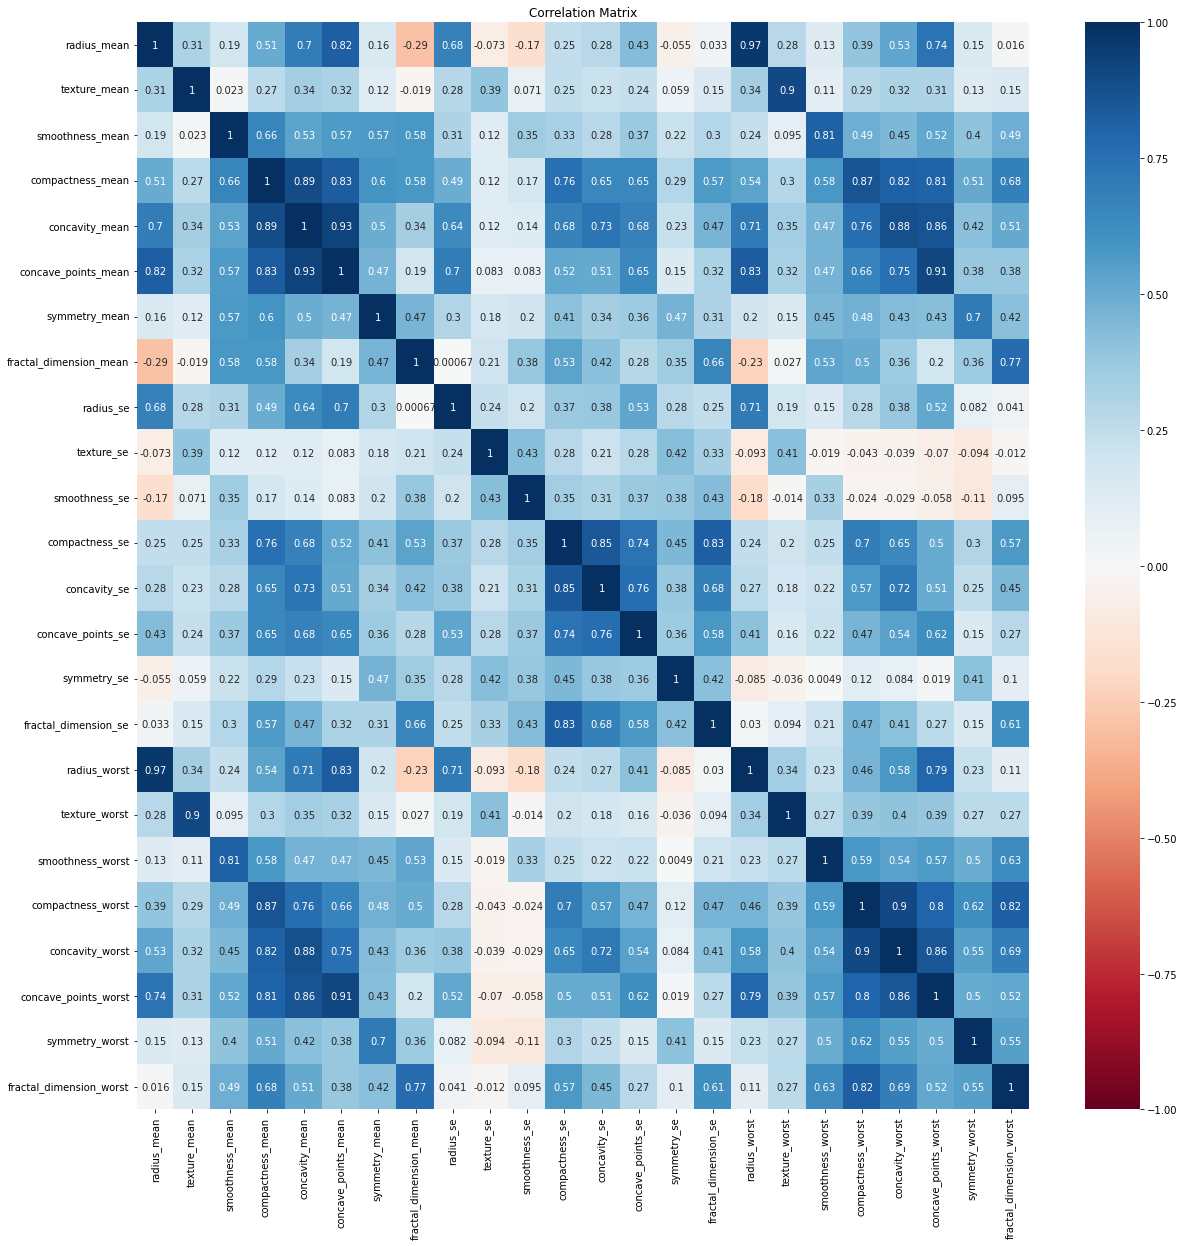

In [ ]:
# test the correlation among features
plt.figure(figsize=(20,20))
sns.heatmap(train_df[features].corr(),annot=True, cmap='RdBu', vmin=-1, vmax=1)
plt.title('Correlation Matrix');

# !!!!!
# high correlation between radius, perimeter, area --> keep just one of these features!

In [ ]:
train_df[features].corr()

,radius_mean,texture_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,...,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
radius_mean,1.000000,0.313075,0.193081,0.507545,0.697067,0.823964,0.159234,-0.289079,0.677386,-0.073005,...,-0.055146,0.033007,0.967954,0.279889,0.131332,0.394856,0.528070,0.740542,0.150133,0.016301
texture_mean,0.313075,1.000000,0.022957,0.270683,0.337288,0.315523,0.123507,-0.018920,0.283062,0.394541,...,0.059355,0.151957,0.339840,0.903865,0.106470,0.288683,0.317885,0.305356,0.131711,0.149215
smoothness_mean,0.193081,0.022957,1.000000,0.658882,0.534375,0.569606,0.570573,0.580177,0.308042,0.119922,...,0.221098,0.295613,0.235281,0.094573,0.814589,0.486155,0.449460,0.517818,0.403906,0.491981
compactness_mean,0.507545,0.270683,0.658882,1.000000,0.891036,0.831360,0.600266,0.584872,0.493250,0.117897,...,0.290491,0.569650,0.537594,0.295179,0.578875,0.865312,0.820009,0.810156,0.514950,0.682314
concavity_mean,0.697067,0.337288,0.534375,0.891036,1.000000,0.928763,0.496390,0.336101,0.636147,0.121463,...,0.231400,0.465730,0.710581,0.345542,0.470974,0.762188,0.882006,0.864728,0.418767,0.511481
concave_points_mean,0.823964,0.315523,0.569606,0.831360,0.928763,1.000000,0.470519,0.189334,0.696786,0.082627,...,0.151677,0.320309,0.834305,0.323124,0.471435,0.664288,0.753004,0.908250,0.375033,0.377617
symmetry_mean,0.159234,0.123507,0.570573,0.600266,0.496390,0.470519,1.000000,0.466080,0.303652,0.178098,...,0.473684,0.309245,0.198655,0.145828,0.445363,0.478295,0.431410,0.427354,0.704650,0.419160
fractal_dimension_mean,-0.289079,-0.018920,0.580177,0.584872,0.336101,0.189334,0.466080,1.000000,0.000666,0.209351,...,0.352835,0.657697,-0.230884,0.026894,0.528789,0.500358,0.361130,0.195101,0.362090,0.771283
radius_se,0.677386,0.283062,0.308042,0.493250,0.636147,0.696786,0.303652,0.000666,1.000000,0.235680,...,0.279262,0.249142,0.707665,0.190033,0.147239,0.276643,0.375897,0.518338,0.081784,0.041440
texture_se,-0.073005,0.394541,0.119922,0.117897,0.121463,0.082627,0.178098,0.209351,0.235680,1.000000,...,0.423247,0.330551,-0.093104,0.414505,-0.019030,-0.042610,-0.038587,-0.070055,-0.093869,-0.011505


In [ ]:
# removed radius_worse, highly correlating with radius_mean
# that might have caused a singular matrix

formula_features = ''
for i in [i for i in features if 'radius_worse' not in i]:
  i = i.replace(' ', '_')
  formula_features = i + " + " + formula_features
formula_features = formula_features[:-3]

model = smf.logit("output ~ %s" %formula_features, data = train_df).fit()
model.summary()

# nope, still singular matrix

         Current function value: inf
         Iterations: 35


/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:1863: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


LinAlgError: ignored

In [ ]:
# removed some features (concavity, highly correlating with concave points)
# that might have caused a singular matrix

formula_features = ''
for i in [i for i in features if 'concavity' not in i]:
  i = i.replace(' ', '_')
  formula_features = i + " + " + formula_features
formula_features = formula_features[:-3]

model = smf.logit("output ~ %s" %formula_features, data = train_df).fit()
model.summary()


Optimization terminated successfully.
         Current function value: 0.034396
         Iterations 14


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 output   No. Observations:                  455
Model:                          Logit   Df Residuals:                      433
Method:                           MLE   Df Model:                           21
Date:                Thu, 27 Oct 2022   Pseudo R-squ.:                  0.9476
Time:                        18:21:59   Log-Likelihood:                -15.650
converged:                       True   LL-Null:                       -298.55
Covariance Type:            nonrobust   LLR p-value:                2.454e-106
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.6456      0.884      0.730      0.465      -1.088       2.379
fractal_dimension_worst     9.1896      3.846      2.390      0.017       1.653      16.727
symmetry_worst              0.9747      2.127      0.458      0.647      -3.194       5.143
concave_points_worst       -3.4367      5.084     -0.676      0.499     -13.401       6.528
compactness_worst          -0.0365      4.663     -0.008      0.994      -9.175       9.102
smoothness_worst            0.2788      2.286      0.122      0.903      -4.201       4.759
texture_worst               6.2399      2.859      2.182      0.029       0.635      11.844
radius_worst               28.5098     11.148      2.557      0.011       6.659      50.360
fractal_dimension_se       -6.6997      3.517     -1.905      0.057     -13.593       0.194
symmetry_se                -0.1699      1.584     -0.107      0.915      -3.275       2.935
concave_points_se           7.0482      3.168      2.225      0.026       0.839      13.258
compactness_se              0.3195      2.701      0.118      0.906      -4.974       5.613
smoothness_se              -0.1086      1.490     -0.073      0.942      -3.029       2.812
texture_se                 -0.9405      1.521     -0.618      0.536      -3.922       2.041
radius_se                   5.6752      3.862      1.470      0.142      -1.894      13.244
fractal_dimension_mean     -0.4214      2.471     -0.171      0.865      -5.265       4.422
symmetry_mean               0.6565      1.587      0.414      0.679      -2.453       3.766
concave_points_mean        10.1020      4.674      2.161      0.031       0.940      19.263
compactness_mean           -9.8178      5.373     -1.827      0.068     -20.348       0.712
smoothness_mean             1.9736      1.903      1.037      0.300      -1.757       5.704
texture_mean               -0.2676      2.148     -0.125      0.901      -4.478       3.942
radius_mean               -13.2541      7.822     -1.694      0.090     -28.585       2.077
===========================================================================================

Possibly complete quasi-separation: A fraction 0.81 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

### Making predictions and evaluating the model

Testing the predictions on the train dataset

In [ ]:
new_features = [i for i in features if 'concavity' not in i]

In [ ]:
# predict the output on the train dataset
train_preds = model.predict(train_df[new_features])

In [ ]:
train_preds

544    6.901708e-08
226    1.337385e-13
325    4.112616e-11
559    4.489693e-05
141    1.000000e+00
           ...     
24     1.000000e+00
18     1.000000e+00
240    1.387965e-06
173    4.076773e-14
220    5.503656e-09
Length: 455, dtype: float64

In [ ]:
# round the result to have the predicted diagnosis
round(train_preds)

544    0.0
226    0.0
325    0.0
559    0.0
141    1.0
      ... 
24     1.0
18     1.0
240    0.0
173    0.0
220    0.0
Length: 455, dtype: float64


**Use metrics to evaluate the goodness of the model**

1 — Precision: It is implied as the measure of the correctly identified positive cases from all the predicted positive cases. Thus, it is useful when the costs of False Positives is high.

2 — Recall: It is the measure of the correctly identified positive cases from all the actual positive cases. It is important when the cost of False Negatives is high.

3 — Accuracy: One of the more obvious metrics, it is the measure of all the correctly identified cases. It is most used when all the classes are equally important.

4 — F1-score: This is the harmonic mean of Precision and Recall and gives a better measure of the incorrectly classified cases than the Accuracy Metric.

In [ ]:
from sklearn import metrics
def getresults(test,pred_variable):
  precision = metrics.precision_score(test,pred_variable,  pos_label=1, average="binary")
  recall =  metrics.recall_score(test,pred_variable,  pos_label=1, average="binary")
  accuracy = metrics.accuracy_score(test,pred_variable)
  f1 = metrics.f1_score(test,pred_variable,  pos_label=1, average="binary")
  return print(' Precision:{:.2f}% \n'.format(100*precision) ,
               'Recall: {:.2f}% \n'.format(100*recall),
               "Accuracy :{:.2f}% \n".format(100*accuracy),
               "F1 :{:.2f}% \n".format(100*f1))

In [ ]:
getresults(train_df['output'],round(train_preds))

 Precision:97.02% 
 Recall: 98.19% 
 Accuracy :98.24% 
 F1 :97.60% 



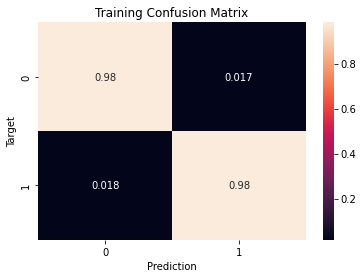

In [ ]:
from sklearn.metrics import confusion_matrix
cf =confusion_matrix(train_df['output'], round(train_preds), normalize='true')
sns.heatmap(cf, annot=True)
plt.xlabel('Prediction')
plt.ylabel('Target')
plt.title('Training Confusion Matrix');

Testing the predictions on the test dataset

 Precision:91.67% 
 Recall: 95.65% 
 Accuracy :94.74% 
 F1 :93.62% 



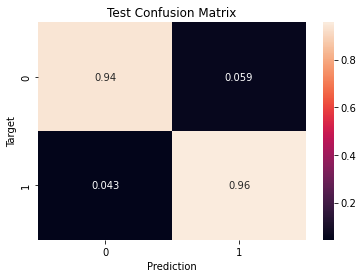

In [ ]:
test_preds = model.predict(test_df[features])
getresults(test_df['output'],round(test_preds))


cf =confusion_matrix(test_df['output'], round(test_preds), normalize='true')
sns.heatmap(cf, annot=True)
plt.xlabel('Prediction')
plt.ylabel('Target')
plt.title('Test Confusion Matrix');
